## Dependencies

In [2]:
import pandas as pd 
from CreditScoringToolkit import frequency_table
from CreditScoringToolkit import DiscreteNormalizer
from CreditScoringToolkit import WoeEncoder
from CreditScoringToolkit import WoeContinuousFeatureSelector
from CreditScoringToolkit import WoeDiscreteFeatureSelector
from CreditScoringToolkit import CreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._discretization")

## Reading example data

In [3]:
#  Read example data for train and validation (loan applications)
train = pd.read_csv('example_data/train.csv')
valid = pd.read_csv('example_data/valid.csv')   

## Defining feature type

In [4]:
#  Assign features lists by type, file contains "C_" prefix for continuous, and "D_" for discrete.
vard = [v for v in train.columns if v[:2]=='D_']
varc = [v for v in train.columns if v[:2]=='C_']

## Normalize Discrete Features

In [ ]:
#  In this example, we aggregate categories with less than 10% of relative frequency
#  into a new category called 'SMALL CATEGORIES', if new created category don't reach
#  given relative frequency threshold (10%) then the most frequent category is imputed.
#  All missing values are treatead as the separate category MISSING

dn = DiscreteNormalizer(normalization_threshold=0.1,default_category='SMALL CATEGORIES')
dn.fit(train[vard])
Xt = dn.transform(train[vard])
frequency_table(Xt,vard)

### Check if Normalization process didn't produce unary features

In [ ]:
unary = [v for v in vard if Xt[v].nunique()==1]
unary

## WoE Based Best Feature Selection

In [ ]:
#   Now we proceed with feature selection, we have special classes for each type of feature (discrete,continuous)
#   Discrete feature selector uses the given iv_threshold to select the best features only.
#   For continuous feature selector, a variety of methods are available for selecting the best features , namely:
#    -uniform: only uses equal-width discretized bins, selects number of bins with best IV value.  
#    -quantile: only uses equal-frequency discretized bins, selects number of bins with best IV value 
#    -kmeans: only uses discretized bins created by a K-Means clustering, selects number of bins with best IV value 
#    -gaussian: only uses discretized bins created by a Gaussian Mixture, selects number of bins with best IV value
#    -dcc: stands for Discrete Competitive Combination, creates segments for all individual methods and then 
#          selects the best method and its corresponding best number of bins for each feature.
#    -dec: stands for Discrete Exhaustive Combination, creates segments for all individual methods and then 
#          selects the best number of bins for each feature including every feasible method.
#
#   One can configure IV threshold, minimun/maximum number of discretization bins, whether or not to keep only
#   strictly monotonic segments and the number of pooling threads used in order to speed computations. 


Xt = pd.concat([Xt,train[varc]],axis=1) #Merge continuous features matrix with the normalized discrete predictors Matrix

wcf = WoeContinuousFeatureSelector()
wdf = WoeDiscreteFeatureSelector()

#  Perform feature selection
wcf.fit(Xt[varc],train['TARGET'],
        max_bins=6,
        strictly_monotonic=True,
        iv_threshold=0.05,
        method='dcc',
        n_threads=20)

wdf.fit(Xt[vard],train['TARGET'],iv_threshold=0.1)

#  Create new matrix with discrete and discretized best features 
Xt = pd.concat([wdf.transform(Xt[vard]),wcf.transform(Xt[varc])],axis=1)

features = list(Xt.columns)

#  Print selection results
print("Best continuous features: ", wcf.selected_features)
print("Best discrete features: ",wdf.selected_features)
print("Best Features selected: ",features)

## WoE Transformation 

In [ ]:
#  Weight of Evidence Transformation
we = WoeEncoder()
we.fit(Xt[features],train['TARGET'])
Xwt = we.transform(Xt[features])
Xwt.head()

## Logistic Regression Parameter Learning

In [ ]:
lr = LogisticRegression()
lr.fit(Xwt,train['TARGET'])
print("AUC for training: ",roc_auc_score(y_score=lr.predict_proba(Xwt)[:,1],y_true=train['TARGET']))

## Scoring

In [ ]:
#  In order to perform the scoring transformation, we need the WoE encoded data, 
#  the WoeEncoder fitted object and the logistic regression fitter object 
#  to produce a nice formatted scorecard
cs = CreditScoring()
cs.fit(Xwt,we,lr)
cs.scorecard

## Validation

### Model Generalization

In [ ]:
#  Applying all transformations to the validation data is now easy and straightforward
#  we can compute AUC to check model overfitting
Xv = pd.concat([wdf.transform(dn.transform(valid[vard])),wcf.transform(valid[varc])],axis=1)
Xwv = we.transform(Xv)
print("AUC for validation: ",roc_auc_score(y_score=lr.predict_proba(Xwv)[:,1],y_true=valid['TARGET']))

### Scoring Distributions

In [ ]:
#  We can check the score transformation distributions for training and validation
score = pd.concat([pd.concat([cs.transform(we.inverse_transform(Xwv))[['score']].assign(sample='validation'),valid['TARGET']],axis=1),
pd.concat([cs.transform(we.inverse_transform(Xwt))[['score']].assign(sample='train'),train['TARGET']],axis=1)
                  ],ignore_index=True)

for s,d in score.groupby('sample'):
    plt.figure()
    plt.title(s)
    sns.histplot(d['score'],legend=True,fill=True,bins=8)

### Event rates

In [ ]:
#   We can observe that, the greater the score, the lower the probability of being a 
#   bad customer (label=1) for both samples. Now all complexity is absorbed   
score['score_range'] = pd.cut(score['score'],bins=6,include_lowest=True).astype(str)
for s,d in score.groupby('sample'):
    aux = d.pivot_table(index='TARGET',
                        columns='score_range',
                        values='score',
                        aggfunc='count',
                        fill_value=0)
    aux/=aux.sum()
    aux = aux.T
    plt.figure()
    ax = aux.plot(kind='bar',stacked=True,color=['purple','black'])
    plt.title(s)

/Users/josegustavofuentescabrera/entornos/woe/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/josegustavofuentescabrera/entornos/woe/lib/python3.13/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. C

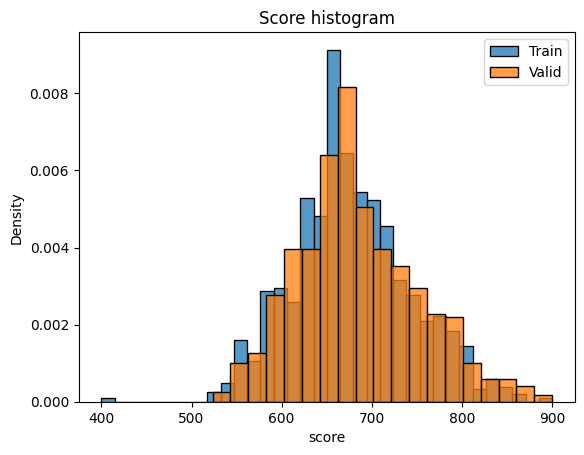

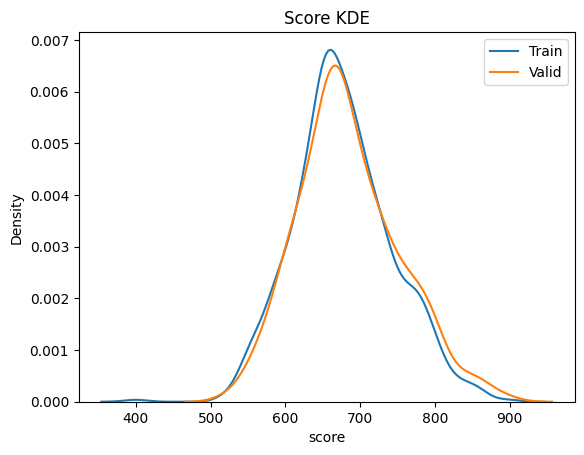

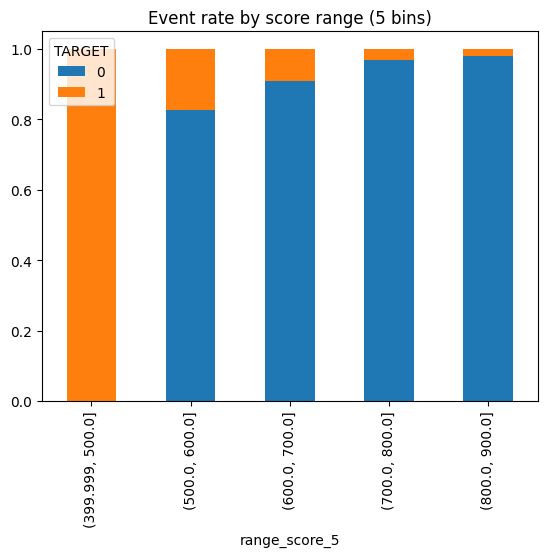

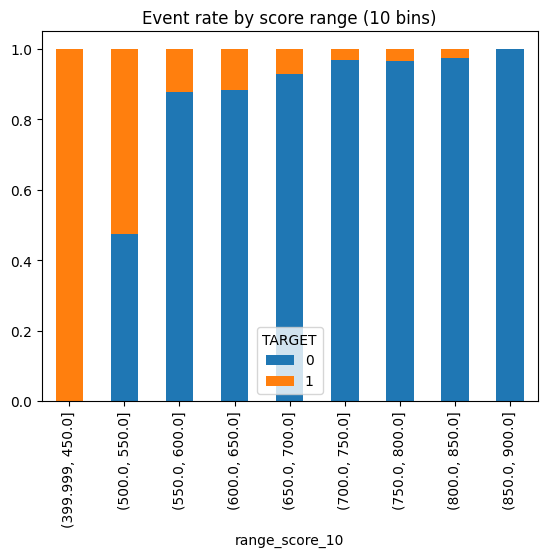

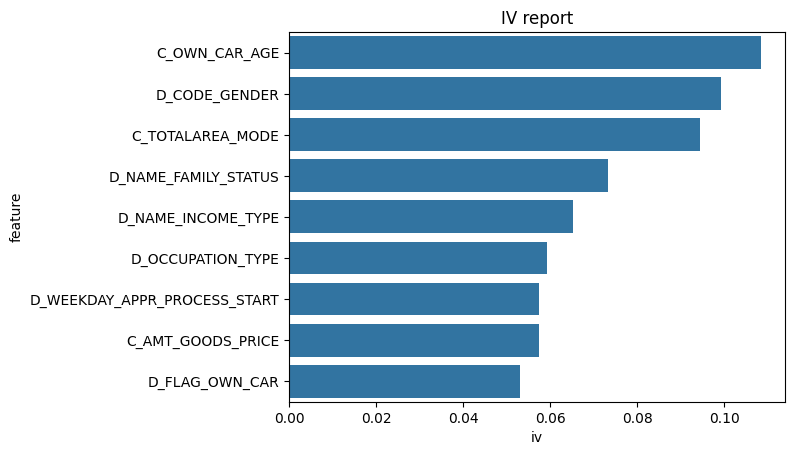

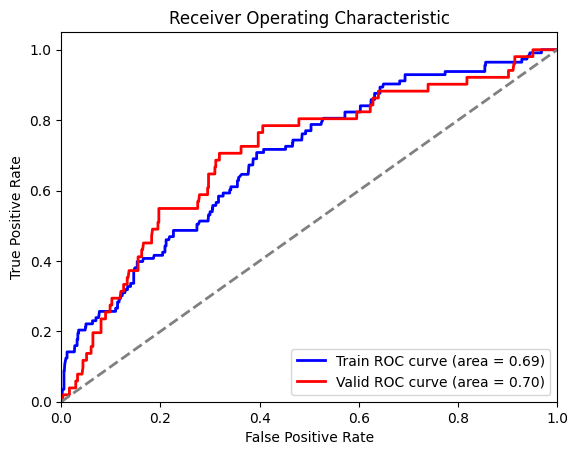

In [ ]:
# If you prefer, use AutoCreditScoring class to perform all the steps in a single call with additional features
# like outlier detection and treatment, feature selection, reporting and more.
from CreditScoringToolkit import AutoCreditScoring

data = pd.concat([train,valid],axis=0)
kwargs = {'iv_feature_threshold':0.02,'max_discretization_bins':6,'strictly_monotonic':True}
acs = AutoCreditScoring(data,'TARGET',varc,vard)
acs.fit(**kwargs)

# You can also save the reports to a folder in PNG format
acs.save_reports('reports')